<a href="https://colab.research.google.com/github/UnikaGhimire/LLM-From-Scratch/blob/main/GPT_from_Scratch_To_Generate_Texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##No training version

In [ ]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

# Our main goal is to get a output that gives us the highest value for the token
# that the LLM thinks comes next.
# In other words, we can say our goal is to generate a new text one word at a time.
# We extract the highest value, get the token ID and decode it.

matplotlib version: 3.10.0
torch version: 2.9.0+cu126
tiktoken version: 0.12.0


In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers, transformer blocks
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [ ]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
print(batch)
batch = torch.stack(batch, dim=0)
print(batch)

[tensor([6109, 3626, 6100,  345]), tensor([6109, 1110, 6622,  257])]
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M) # inititalizing the model

logits = model(batch)
print("Output shape:", logits.shape)
print(logits) # these are the raw preds (logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


##Normalizing activations with layer normalization

Layer Normalization, also known as Layer Norm centers the activations of a neural network layer around the mean of 0 and normalizes their variance to 1.

Layer normalization is applied both before and after the multi-head attention module within the transformer block, which we will implement later; it's also applied before the final output layer

In [ ]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


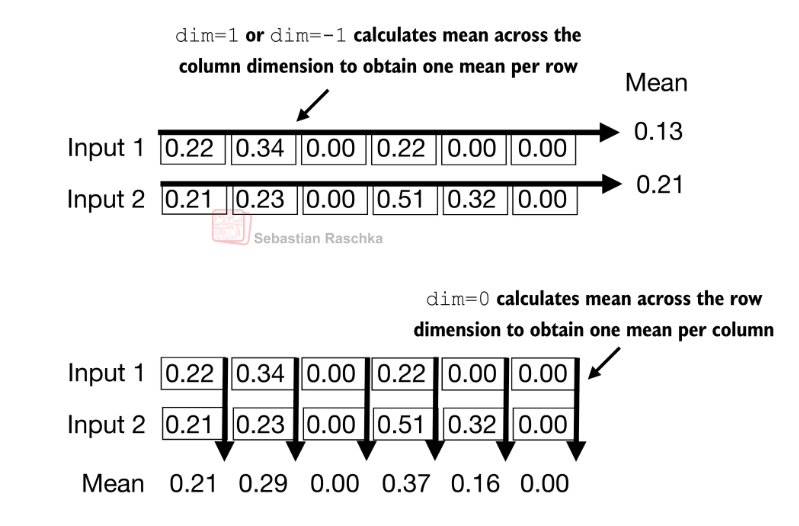

In [ ]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [ ]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## More about the Scale and Shift Operation

This operation provides flexibility. Sometimes, few layers do not need to be normalized at all, or they might do better with slightly different values than the normalized ones. So, we allow the model to decide for itself what's best for it.

Scale is known as gamma and Shift is known as beta. They are per feature learnable parameters.

Scale is 1 and Shift is 0 initially.

Shift is a value that gets added while Scale is a value that gets multiplied that is why they are 0 ans 1 initially so that they do not change anything at first.

##Scaling :    

It makes the normalized value smaller or bigger. The distance between numbers increases or decreases. Feature is either shrunked or enlarged by multiplying.

If the feature is too small (close to 0), the neuron’s signal might be too weak

If the feature is too large, it might dominate other signals

Scaling lets the model learn the correct “strength” for each feature.

##Shifting :    

Shift allows the model to restore or move the baseline. It adds a value to the feature. A feature in a model represents how important it is. Before normalization, important words = values around 5–10, unimportant = 0–1

But after normalization:

All values are centered around 0.

Now, the model loses the sense of “baseline importance”.

Shift allows the model to restore or move the baseline:

```
Positive shift → features stay “important”
Negative shift → features stay “less important”
```

Some neurons work best if their input is slightly positive (e.g., for ReLU activations)

Shift lets the network move the normalized values into that optimal range.

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 0.0005 # this is to avoid diving by zero later
    self.scale = nn.Parameter(torch.ones(emb_dim)) # multiply
    self.shift = nn.Parameter(torch.zeros(emb_dim)) # add

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim = -1, keepdim = True, unbiased = False) # unbiased=False → divide by N instead of N-1
    norm_x = (x-mean) / torch.sqrt(var + self.eps) # adding to avoid division-by-zero errors if the variance is 0
    return self.scale * norm_x + self.shift

In [ ]:
ln = LayerNormalization(6)
out_ln = ln(out)
out_ln

tensor([[ 0.6660,  1.5276, -0.9429,  0.6351, -0.9429, -0.9429],
        [-0.0205,  0.1219, -1.1826,  1.6497,  0.6140, -1.1826]],
       grad_fn=<AddBackward0>)

In [ ]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.9746],
        [0.9852]], grad_fn=<VarBackward0>)


## Implementing a feed forward network with GELU Activations

GELU stand for Gaussian Error Linear Unit. It is used instead of using simple ReLU in LLMs. Along with GELU, we can also use SwiGLU which stands for Swish-Gated Linear Unit.

We will be using GELU here.

GELU and SwiGLU are more complex and smooth activation functions incorpo
rating Gaussian and sigmoid-gated linear units, respectively. They offer improved per
formance for deep learning models, unlike the simpler ReLU.
 The GELU activation function can be implemented in several ways; the exact version is defined as GELU(x) = x⋅Φ(x),

where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.

But, we will be using a simpler version.

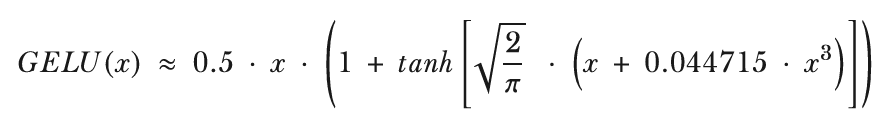

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

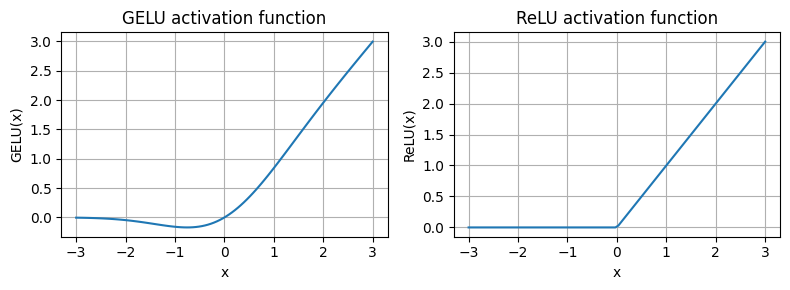

In [ ]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

Negative numbers are scaled down, not zeroed out

Positive numbers are mostly passed through

That’s why GELU is “smooth” and helps gradients flow.

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), # we can change 4 to anything
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]) # matching the shape to input for residual connections
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


The FeedForward module plays a crucial role in enhancing the model’s ability to learn
 from and generalize the data. Although the input and output dimensions of this
 module are the same, it internally expands the embedding dimension into a higher
dimensional space through the first linear layer.

This expansion is followed by a nonlinear GELU activation and then a contraction back to the orig
inal dimension with the second linear transformation. Such a design allows for the
 exploration of a richer representation space

##Adding shortcut connections ( Skip or Residual Connections )




When we are training a shallow Neural Network, we see a large decrease in the loss in the first few epochs of training but if we build a Deep Neural Network out of dense or Convolutional Layers, the loss graph doesn't decrease even if we run a lot of epochs.

Let's think about what happens when we pass data through a DNN. When we initialize a deep a deep NN, all fo the layers have radnomly chosen weights and so when we pass the input through each layer of the network, the activations are ebing multiplied by a random weight matrix.

If we do this many times, by the time the data gets to the output layer, almost non of the output we are producing is a signal related to the input.

We are basically scrambling the input into random noise.

And when we perform on output, we will compute the loss on the output and backpropagate it back through the network but that loss may not be very informative at the layers late in the network because the input to those layers were basically random noise.

And when we pass gradients back through the networks, each layer gets deltas multiplied by it's weight matrix so by the time we get back to the early layers that had inputs with some meaningful connection to the data, the gradients have also been scrambled by many multiplications of random weight matrices.

So, the updates we do to later layers do not mean much.

###Skip Connection's Idea

It's idea is to group up layers of the network into blocks and for ech block have data go both through and around.

Instead of having a single pathway for the information flow, residual connections are about adding another shortcut pathways to pass the input to the later layers.




In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()), # layer_sizes = list of number of neurons per layer
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [ ]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


##Connecting attention and linear layers in a transformer block

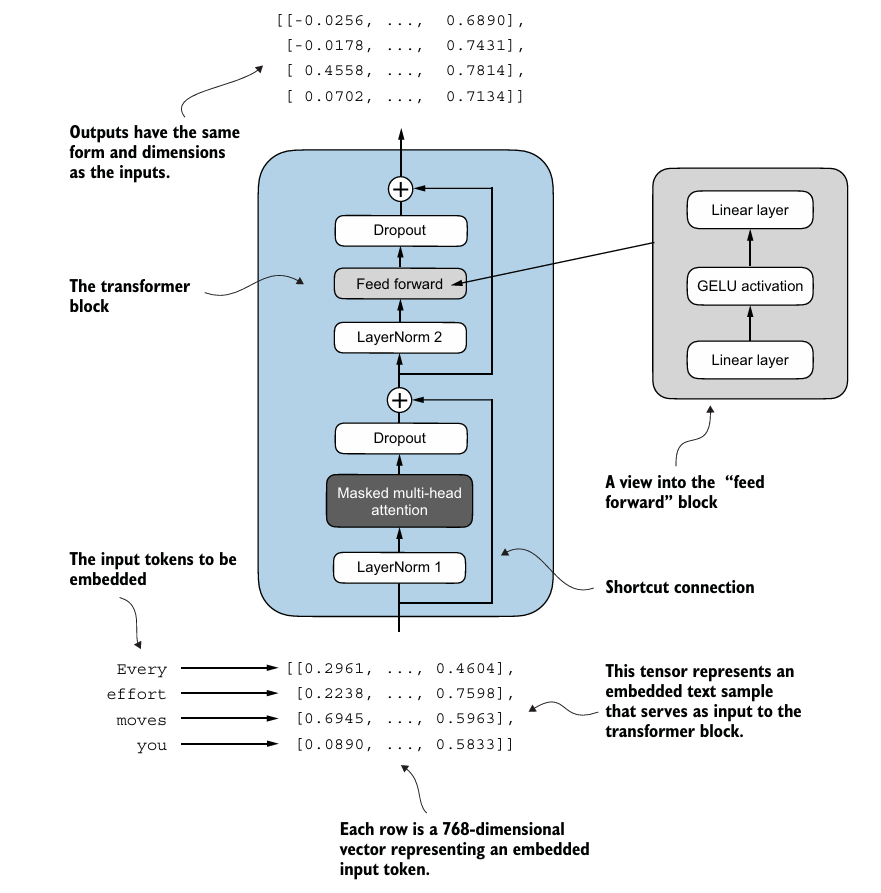

In [ ]:
# head_dim = dimension of the context vector before we concatenate them
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # As in `CausalAttention`, for inputs where `num_tokens` exceeds `context_length`,
        # this will result in errors in the mask creation further below.
        # In practice, this is not a problem since the LLM (chapters 4-7) ensures that inputs
        # do not exceed `context_length` before reaching this forward method.

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

# The 'batch' tensor from cell 47pQu8MnNjpC is of shape [2, 4].
# The MultiHeadAttention expects a 3D input [batch_size, num_tokens, d_in].
# We need to embed the batch first to get the d_in dimension.
# Using GPT_CONFIG_124M to get vocab_size and emb_dim for the embedding layer.
vocab_size = GPT_CONFIG_124M["vocab_size"]
emb_dim = GPT_CONFIG_124M["emb_dim"]
embedding_layer = nn.Embedding(vocab_size, emb_dim)
embedded_batch = embedding_layer(batch) # 'batch' is already defined from cell 47pQu8MnNjpC

batch_size, context_length, d_in = embedded_batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(embedded_batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4254, -0.6054],
         [-0.4180, -0.5809],
         [-0.3952, -0.5214],
         [-0.4177, -0.5277]],

        [[-0.4254, -0.6054],
         [-0.3711, -0.6057],
         [-0.3883, -0.6245],
         [-0.4437, -0.5707]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 4, 2])


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNormalization(cfg["emb_dim"])
        self.norm2 = LayerNormalization(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [ ]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## Coding the GPT model

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNormalization(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2837],
         [-0.1791, -0.5660, -0.9484,  ...,  0.0477,  0.5180, -0.3167],
         [ 0.7119,  0.0333,  0.1084,  ...,  0.1018, -0.4328, -0.2552],
         [-1.0075,  0.3419, -0.1190,  ...,  0.7195,  0.4022,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4453, -0.6805],
         [ 0.1230,  0.3653, -0.2073,  ...,  0.7705,  0.2709,  0.2246],
         [ 1.0558,  1.0317, -0.2799,  ...,  0.6936,  0.3205, -0.3177],
         [-0.1564,  0.3926,  0.3288,  ...,  1.2630, -0.1859,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


As we see above, this model has 163M, not 124M parameters; why?

In the original GPT-2 paper, the researchers applied weight tying, which means that they reused the token embedding layer (tok_emb) as the output layer, which means setting self.out_head.weight = self.tok_emb.weight


The token embedding layer projects the 50,257-dimensional one-hot encoded input tokens to a 768-dimensional embedding representation
The output layer projects 768-dimensional embeddings back into a 50,257-dimensional representation so that we can convert these back into words.


So, the embedding and output layer have the same number of weight parameters, as we can see based on the shape of their weight matrices
However, a quick note about its size: we previously referred to it as a 124M parameter model; we can double check this number as follows.

In [ ]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [ ]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [ ]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


##Generating Texts

The following generate_text_simple function implements greedy decoding, which is a simple and fast method to generate text.

In greedy decoding, at each step, the model chooses the word (or token) with the highest probability as its next output (the highest logit corresponds to the highest probability, so we technically wouldn't even have to compute the softmax function explicitly).

In [62]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # After max_new_tokens iterations, idx contains:
        # Original tokens and All newly generated tokens

    return idx

In [63]:
start_context = "Lionel Messi is"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [43, 295, 417, 36128, 318]
encoded_tensor.shape: torch.Size([1, 5])


In [64]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[   43,   295,   417, 36128,   318, 43423,   867, 18445, 26005,  9988,
         22580]])
Output length: 11


In [65]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Lionel Messi is hauled manyrikes embracing installation valve


Since the model is untrained, the result is gibberish.